In [1]:
%load_ext autoreload
%autoreload 2

# Conditional VAE for genetic circuits

This notebook follows the previous VAE notebook very closely, but implementing a conditional VAE instead. Loosely following [this blog post](https://agustinus.kristia.de/techblog/2016/12/17/conditional-vae/) with the associated [github](https://github.com/wiseodd/generative-models/blob/master/VAE/conditional_vae/cvae_pytorch.py).

## Imports 

In [2]:
from synbio_morpher.utils.data.data_format_tools.common import load_json_as_dict
from synbio_morpher.utils.results.analytics.naming import get_true_interaction_cols
from synbio_morpher.utils.results.analytics.timeseries import calculate_adaptation
from synbio_morpher.utils.data.data_format_tools.common import write_json
from functools import partial

from sklearn.metrics import r2_score  
import os

USE_ONLY_ONE_GPU = True
if USE_ONLY_ONE_GPU:
    os.environ["CUDA_VISIBLE_DEVICES"] = "1"  # 0 or 1

import sys
import numpy as np
import haiku as hk
import jax
import optax

from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import shuffle

import wandb

from datetime import datetime
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

jax.config.update('jax_platform_name', 'gpu')


# if __package__ is None:

module_path = os.path.abspath(os.path.join('..'))
sys.path.append(module_path)

__package__ = os.path.basename(module_path)

PRNG = jax.random.PRNGKey(0)

jax.devices()

# jupyter nbconvert --to notebook --execute 01_cvae.ipynb --output=01_cvae_2.ipynb --ExecutePreprocessor.timeout=-1




[cuda(id=0)]

In [3]:
from evoscaper.model.vae import sample_z, VAE_fn
from evoscaper.model.shared import arrayise
from evoscaper.model.loss import loss_wrapper, compute_accuracy_regression, mse_loss, accuracy_regression
from evoscaper.utils.math import convert_to_scientific_exponent
from evoscaper.utils.optimiser import make_optimiser
from evoscaper.utils.train import make_saves
from evoscaper.utils.normalise import make_chain_f, NormalizationSettings
from common import balance_dataset, balance_dataset2d

## Load data

In [4]:
# fn = '../data/raw/summarise_simulation/2024_11_21_144918/tabulated_mutation_info.csv'
# fn = '../data/raw/summarise_simulation/2024_11_21_160955/tabulated_mutation_info.csv'
fn = '../data/raw/summarise_simulation/2024_12_05_210221/tabulated_mutation_info.csv'
# fn_test_data = '../data/raw/summarise_simulation/2023_07_17_222747/tabulated_mutation_info.csv'
# data = pd.concat([pd.read_csv(fn), pd.read_csv(fn_test_data)])
data = pd.read_csv(fn)
len(data)

600000

In [5]:
data['adaptability'] = calculate_adaptation(
    s=data['sensitivity_wrt_species-6'].values, 
    p=data['precision_wrt_species-6'].values)

## Hyperparameters

In [ ]:
# Stats
SEED = 1
PRNG = jax.random.PRNGKey(SEED)

# Architecture
USE_SIGMOID_DECODER = True
HIDDEN_SIZE = 32 # 64
ENC_LS = 64
DEC_LS = 64
NUM_ENC_LAYERS = 1
NUM_DEC_LAYERS = 1
enc_layers = [ENC_LS] * NUM_ENC_LAYERS # [128, 128, 64, 64] # 
dec_layers = [DEC_LS] * NUM_DEC_LAYERS # [64, 64, 128, 128] # 
ENC_INIT = 'HeNormal'
DEC_INIT = 'HeNormal'

# Dataset 
OBJECTIVE_COL = 'adaptability'  # 'sensitivity_wrt_species-6'
include_diffs = False
X_TYPE = 'energies'  # 'binding_rates_dissociation' #  
OUTPUT_SPECIES = ['RNA_2']

# Dataset training
BATCH_SIZE = 128
PREP_X_STANDARDISE = False
PREP_Y_STANDARDISE = False
PREP_X_MINMAX = False
PREP_Y_MINMAX = False
PREP_X_ROBUST_SCALING = True
PREP_Y_ROBUST_SCALING = True
PREP_X_LOGSCALE = False
PREP_Y_LOGSCALE = False
PREP_X_CATEGORICAL = False
PREP_Y_CATEGORICAL = False
PREP_X_NEG = False
PREP_Y_NEG = False
TOTAL_DS = None
TOTAL_DS_MAX = 3e6
N_BATCHES = int(TOTAL_DS_MAX // BATCH_SIZE)

# Training
EPOCHS = 500
LEARNING_RATE = 1e-2
LEARNING_RATE_SCHED = 'cosine_decay'  # 'constant
TRAIN_SPLIT = 0.8
USE_DROPOUT = False
USE_L2_REG = False
USE_KL_DIV = True
USE_WARMUP = True
WARMUP_EPOCHS = 20
L2_REG_ALPHA = 0.01
PRINT_EVERY = EPOCHS // 100

# Loss
loss_fn = partial(
    loss_wrapper, loss_f=mse_loss, use_l2_reg=USE_L2_REG, use_kl_div=USE_KL_DIV) 
compute_accuracy = compute_accuracy_regression

# Save 
TASK = '_robust_KL_e2000'
# TASK = '_test'
save_path = str(datetime.now()).split(' ')[0].replace(
    '-', '_') + '__' + str(datetime.now()).split(' ')[-1].split('.')[0].replace(':', '_') + '_saves' + TASK
save_path = os.path.join('weight_saves', '01_cvae', save_path)
X_COLS = list(get_true_interaction_cols(data, X_TYPE, remove_symmetrical=True))
if include_diffs:
    X_COLS = X_COLS + \
        [[f'{i}_diffs' for i in get_true_interaction_cols(
            data, X_TYPE, remove_symmetrical=True)]]



# Initialise

## Init data

In [7]:
filt = data['sample_name'].isin(OUTPUT_SPECIES) & ~data['precision_wrt_species-6'].isna() & ~data['sensitivity_wrt_species-6'].isna() & (data['precision_wrt_species-6'] < np.inf) & data[OBJECTIVE_COL].notna()

# Balance the dataset
df = data[filt]
# df = drop_duplicates_keep_first_n(df, get_true_interaction_cols(
#     data, X_TYPE, remove_symmetrical=True), n=100)
df.loc[:, 'adaptability'] = df['adaptability'].apply(lambda x: np.round(x, 1))

df = df.reset_index(drop=True)


/tmp/ipykernel_2824752/2614920104.py:7: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[772.4 784.  775.1 ... 724.3 722.3 683. ]' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  df.loc[:, 'adaptability'] = df['adaptability'].apply(lambda x: np.round(x, 1))


### Subsample overrepresented points

Text(0, 0.5, 'Energies mean')

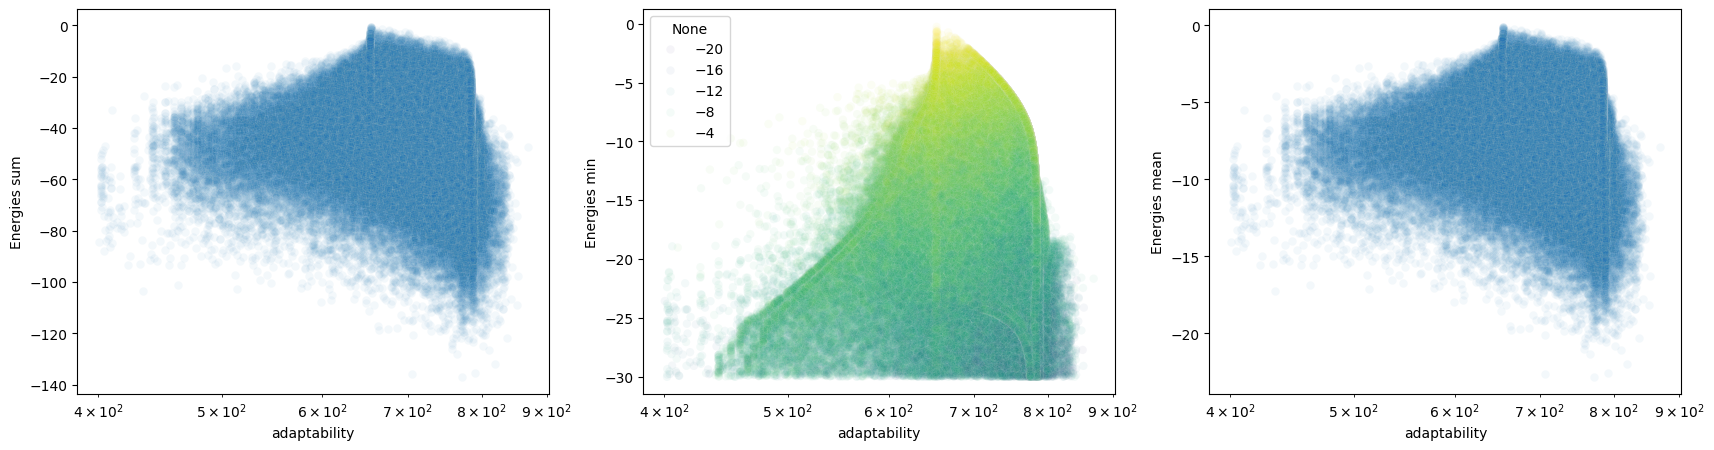

In [8]:
plt.figure(figsize=(4*7, 5))
ax = plt.subplot(1,4,1)
sns.scatterplot(x=df[OBJECTIVE_COL], y=df[X_COLS].sum(axis=1), alpha=0.05)
plt.xscale('log')
plt.ylabel('Energies sum')
ax = plt.subplot(1,4,2)
sns.scatterplot(x=df[OBJECTIVE_COL], y=df[X_COLS].min(axis=1), alpha=0.05,
                hue=df[X_COLS].mean(axis=1), palette='viridis')
plt.xscale('log')
plt.ylabel('Energies min')
ax = plt.subplot(1,4,3)
sns.scatterplot(x=df[OBJECTIVE_COL], y=df[X_COLS].mean(axis=1), alpha=0.05)
plt.xscale('log')
plt.ylabel('Energies mean')

### Reduce circuits that are overrepresented

In [9]:
df = df.reset_index(drop=True)

n_same_circ_max = 100
nbin = 500
agg_func = lambda x: np.sum(x, axis=1)
agg_func = lambda x: tuple(x)

df.loc[:, X_COLS] = df[X_COLS].apply(lambda x: np.round(x, 1))
df_bal = balance_dataset(df, cols=X_COLS, nbin=nbin, 
                         bin_max=n_same_circ_max, use_log=False, func1=agg_func)
df_bal = df_bal.reset_index(drop=True)


Text(0.5, 1.0, 'Adaptability after balancing')

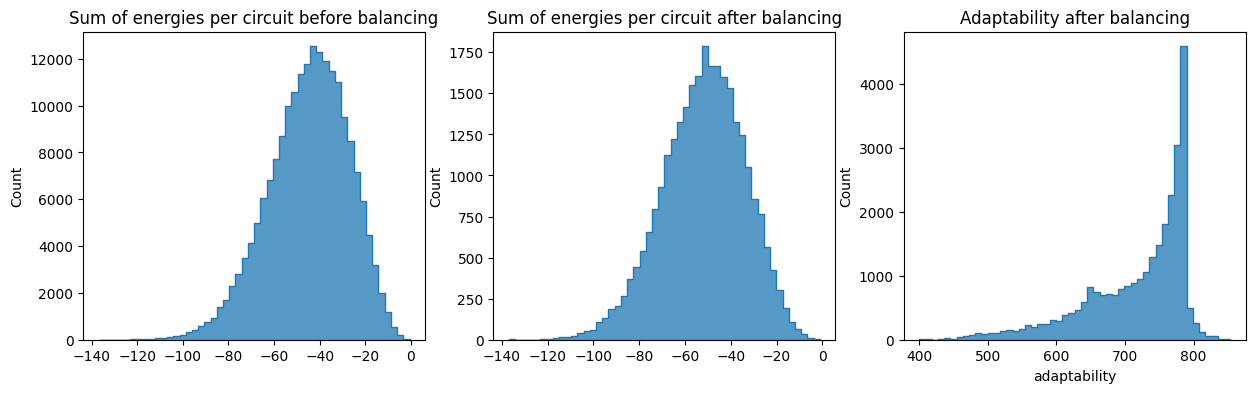

In [10]:
fig = plt.figure(figsize=(5*3, 4))
ax = plt.subplot(1,3,1)
sns.histplot(df[X_COLS].sum(axis=1), bins=50, log_scale=[False, False], element='step')
plt.title('Sum of energies per circuit before balancing')
# ylim = ax.get_ylim()
ax = plt.subplot(1,3,2)
sns.histplot(df_bal[X_COLS].sum(axis=1), bins=50, log_scale=[False, False], element='step')
plt.title('Sum of energies per circuit after balancing')
# plt.ylim(ylim)
ax = plt.subplot(1,3,3)
sns.histplot(df_bal, x='adaptability', bins=50, log_scale=[False, False], element='step')
plt.title('Adaptability after balancing')


Text(0.5, 0.98, 'Energies of species in a peak adaptability range')

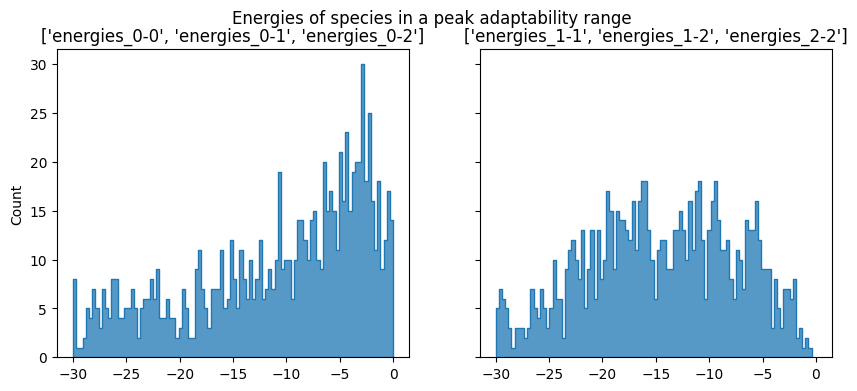

In [11]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4), sharex=True, sharey=True)

sns.histplot(df_bal[df_bal['adaptability'].between(650, 660)][X_COLS[:3]].min(axis=1), bins=100, element='step',
             ax=axs[0], log_scale=[False, False])
axs[0].set_title(X_COLS[:3])
sns.histplot(df_bal[df_bal['adaptability'].between(650, 660)][X_COLS[3:]].min(axis=1), bins=100, element='step',
             ax=axs[1], log_scale=[False, False])
axs[1].set_title(X_COLS[3:])
plt.suptitle('Energies of species in a peak adaptability range')

### Reduce the number of null circuits

In [12]:
# n_null_max = 100
# idxs_null = df[df[X_COLS].sum(axis=1) == 0].index

# df_bal2 = rem_idxs(df, np.random.choice(idxs_null, len(idxs_null) - n_null_max, replace=False))


# fig = plt.figure(figsize=(10,5))
# ax = plt.subplot(1,2,1)
# sns.histplot(df[X_COLS].sum(axis=1), bins=50, element='step')
# plt.title('Before')
# plt.xlabel('Sum of interactions')
# ax = plt.subplot(1,2,2)
# plt.title('After')
# plt.xlabel('Sum of interactions')
# sns.histplot(df_bal2[X_COLS].sum(axis=1), bins=50, element='step')
# plt.suptitle('Balancing null circuits')


In [13]:
# bin_max = int(np.power(10, 3))
# nbin = 50
# func1 = lambda x: np.sum(x, axis=1)
# # df_bal = balance_dataset2d(df_bal, cols1=X_COLS, cols2=OBJECTIVE_COL, nbins=nbin, bin_max=bin_max, use_log=False, func1=func1, func2=None)

# fig = plt.figure(figsize=(10,4))
# ax = plt.subplot(1,2,1)
# sns.histplot(x=df_bal[OBJECTIVE_COL].T, y=func1(df_bal[X_COLS].values).T, bins=nbin, cbar=True)
# plt.title('Before')

# # Need to recurse this subsampling to make it neat
# for i in range(20):
#     df_bal = balance_dataset2d(df_bal, cols1=X_COLS, cols2=OBJECTIVE_COL, nbins=nbin, bin_max=bin_max, use_log=False, func1=func1, func2=None)

# ax = plt.subplot(1,2,2)
# plt.title('After')
# sns.histplot(x=df_bal[OBJECTIVE_COL].T, y=func1(df_bal[X_COLS].values).T, bins=nbin, cbar=True)
# plt.suptitle('Balancing energies + adaptability')

Text(0.5, 0.98, 'Balance of dataset for conditioning variable adaptability')

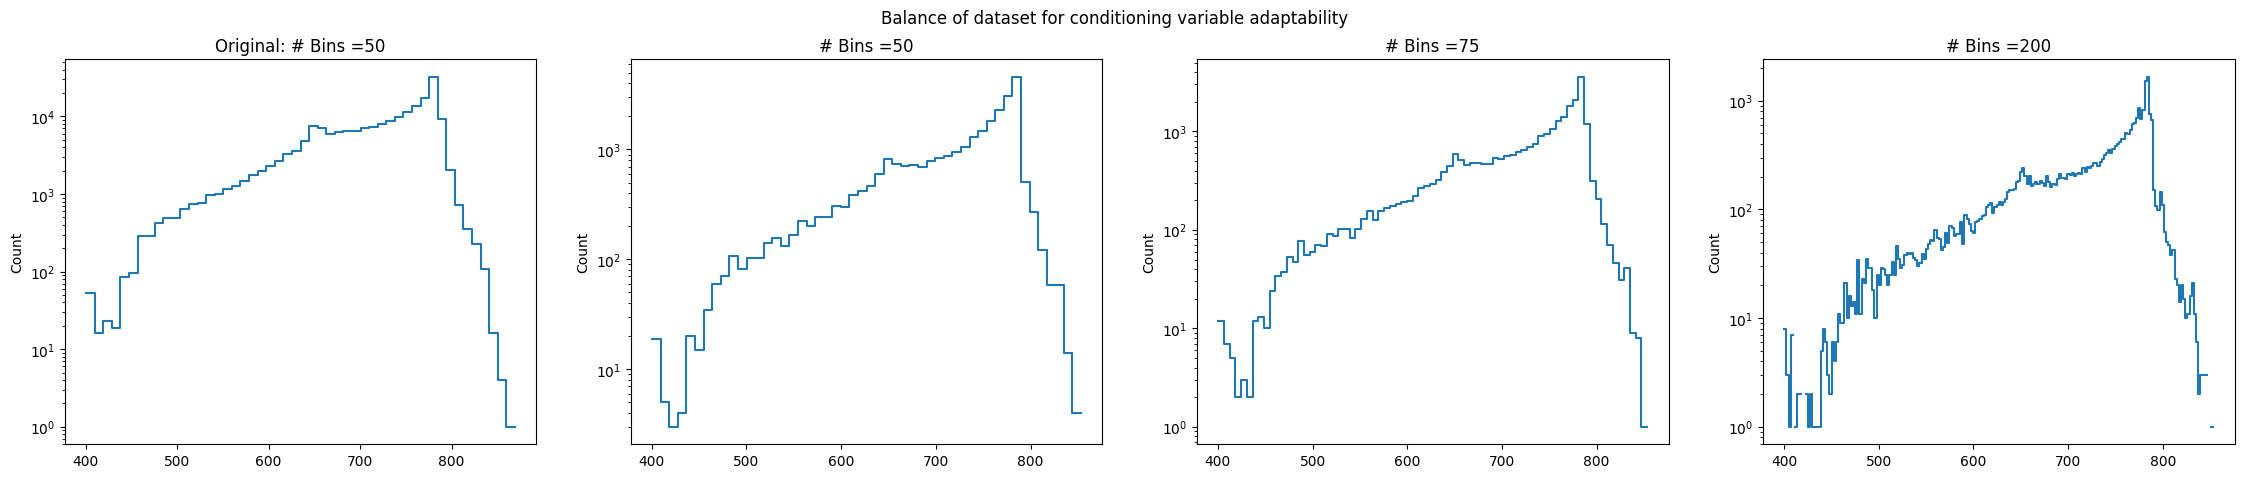

In [14]:
# Balance by bins
nbin = 50
bin_max = int(np.power(10, 4))
# df_bal = balance_dataset(df_bal, cols=OBJECTIVE_COL, nbin=nbin, bin_max=bin_max, use_log=False)
# df_bal = balance_dataset(df, cols=X_COLS, nbin=300, bin_max=bin_max, use_log=False, func1=lambda x: np.sum(x, axis=1))

fig = plt.figure(figsize=(4*7, 5))
ax = plt.subplot(1,4,1)
sns.histplot(df[OBJECTIVE_COL].to_numpy().flatten(), bins=50, log_scale=[False, True], element='step', fill=False)
plt.title('Original: # Bins =' + str(50))
ax = plt.subplot(1,4,2)
sns.histplot(df_bal[OBJECTIVE_COL].to_numpy().flatten(), bins=nbin, log_scale=[False, True], element='step', fill=False)
plt.title('# Bins =' + str(nbin))
ax = plt.subplot(1,4,3)
sns.histplot(df_bal[OBJECTIVE_COL].to_numpy().flatten(), bins=int(nbin*1.5), log_scale=[False, True], element='step', fill=False)
plt.title('# Bins =' + str(int(nbin*1.5)))
ax = plt.subplot(1,4,4)
sns.histplot(df_bal[OBJECTIVE_COL].to_numpy().flatten(), bins=nbin*4, log_scale=[False, True], element='step', fill=False)
plt.title('# Bins =' + str(nbin*4))

plt.suptitle('Balance of dataset for conditioning variable ' + str(OBJECTIVE_COL))


In [15]:
if TOTAL_DS is None:
    TOTAL_DS = len(df_bal)
TOTAL_DS = int(np.min([TOTAL_DS, TOTAL_DS_MAX, len(df_bal)]))
TOTAL_DS = int(TOTAL_DS // BATCH_SIZE * BATCH_SIZE)
N_BATCHES = int(TOTAL_DS // BATCH_SIZE)

### Scale the input data

In [16]:
def f_reshape(i): return i.reshape(N_BATCHES, BATCH_SIZE, i.shape[-1])
def f_unreshape(i): return i.reshape(np.prod(i.shape[:-1]), i.shape[-1])


In [17]:
x = [df_bal[i].iloc[:TOTAL_DS].values[:, None] for i in X_COLS]
x = np.concatenate(x, axis=1).squeeze()
cond = df_bal[OBJECTIVE_COL].iloc[:TOTAL_DS].to_numpy()[:, None]

x_norm_settings = NormalizationSettings(
    negative=PREP_X_NEG,
    log=PREP_X_LOGSCALE,
    standardise=PREP_X_STANDARDISE,
    min_max=PREP_X_MINMAX,
    robust=PREP_X_ROBUST_SCALING,
    categorical=PREP_X_CATEGORICAL
)
y_norm_settings = NormalizationSettings(
    negative=PREP_Y_NEG,
    log=PREP_Y_LOGSCALE,
    standardise=PREP_Y_STANDARDISE,
    min_max=PREP_Y_MINMAX,
    robust=PREP_Y_ROBUST_SCALING,
    categorical=PREP_Y_CATEGORICAL
)
x_datanormaliser, x_methods_preprocessing = make_chain_f(x_norm_settings)
y_datanormaliser, y_methods_preprocessing = make_chain_f(y_norm_settings)
    
x = x_datanormaliser.create_chain_preprocessor(x_methods_preprocessing)(x)
cond = y_datanormaliser.create_chain_preprocessor(y_methods_preprocessing)(cond)
    

# if PREP_Y_CATEGORICAL:

#     vectorized_convert_to_scientific_exponent = np.vectorize(
#         convert_to_scientific_exponent)
#     numerical_resolution = 2
#     cond_map = {k: numerical_resolution for k in np.arange(int(f'{cond[cond != 0].min():.0e}'.split(
#         'e')[1])-1, np.max([int(f'{cond.max():.0e}'.split('e')[1])+1, 0 + 1]))}
#     cond_map[-6] = 1
#     cond_map[-5] = 1
#     cond_map[-4] = 4
#     cond_map[-3] = 2
#     cond_map[-1] = 3
#     cond = jax.tree_util.tree_map(partial(
#         vectorized_convert_to_scientific_exponent, numerical_resolution=cond_map), cond)
#     cond = np.interp(cond, sorted(np.unique(cond)), np.arange(
#         len(sorted(np.unique(cond))))).astype(int)


In [18]:
N_HEAD = x.shape[-1]

# x, cond = shuffle(x, cond, random_state=SEED)

PRNG, shuffle_key = jax.random.split(PRNG)
shuffled_indices = jax.random.permutation(shuffle_key, x.shape[0])
x = x[shuffled_indices]
cond = cond[shuffled_indices]

if x.shape[0] < TOTAL_DS:
    print(
        f'WARNING: The filtered data is not as large as the requested total dataset size: {x.shape[0]} vs. requested {TOTAL_DS}')

In [19]:
cond.shape, x.shape, np.concatenate([x, cond], axis=-1).shape

((28288, 1), (28288, 6), (28288, 7))

Text(0.5, 0.98, 'Dataset after balancing')

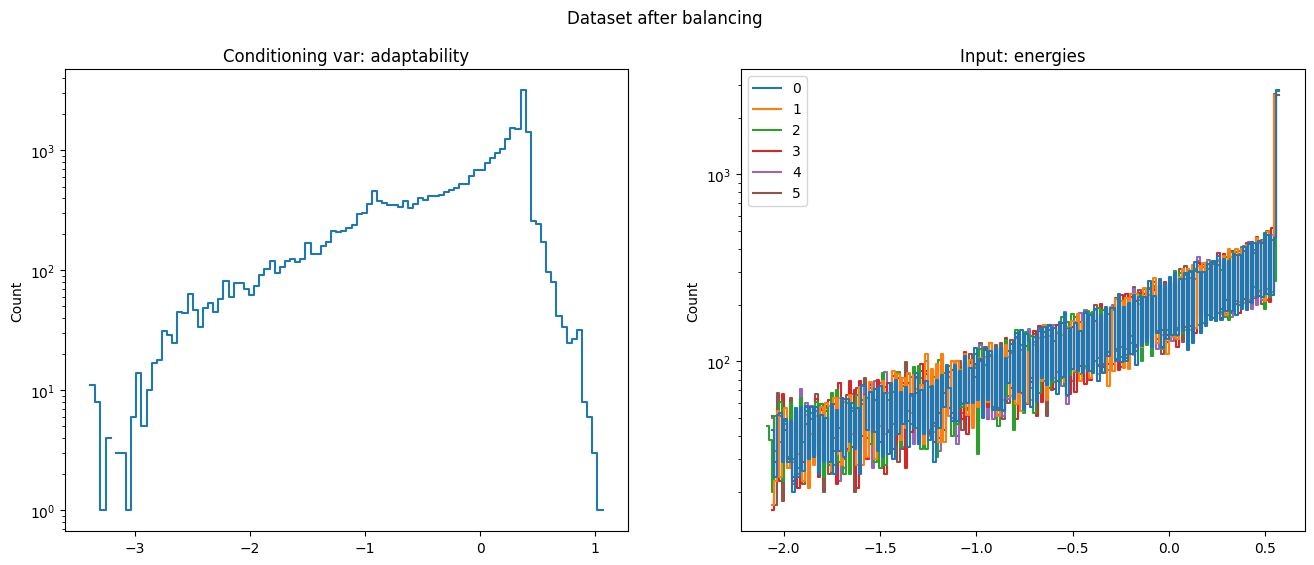

In [20]:
fig = plt.figure(figsize=(2*8, 6))

ax = plt.subplot(1,2,1)
sns.histplot(cond.flatten(), log_scale=[False, True], bins=100, element='step', fill=False)
plt.title(f'Conditioning var: {OBJECTIVE_COL}')

ax = plt.subplot(1,2,2)
sns.histplot(x, element='step', fill=False, bins=200, log_scale=[False, True])
plt.title(f'Input: {X_TYPE}')

plt.suptitle('Dataset after balancing')

## Init model

In [21]:
model_fn = partial(VAE_fn, enc_layers=enc_layers, dec_layers=dec_layers, decoder_head=x.shape[-1], 
                   HIDDEN_SIZE=HIDDEN_SIZE, USE_SIGMOID_DECODER=USE_SIGMOID_DECODER, enc_init=ENC_INIT, dec_init=DEC_INIT)
# model = hk.transform(model_fn)
model_t = hk.multi_transform(model_fn)
params = model_t.init(PRNG, x, cond, deterministic=False)


In [22]:
encoder, decoder, model, h2mu, h2logvar, reparam = model_t.apply


In [23]:
h = encoder(params, PRNG, np.concatenate([x, cond], axis=-1))

In [24]:
model(params, PRNG, x, cond, return_muvar=False).shape

(28288, 6)

Text(0.5, 1.0, 'Initial embedding of model')

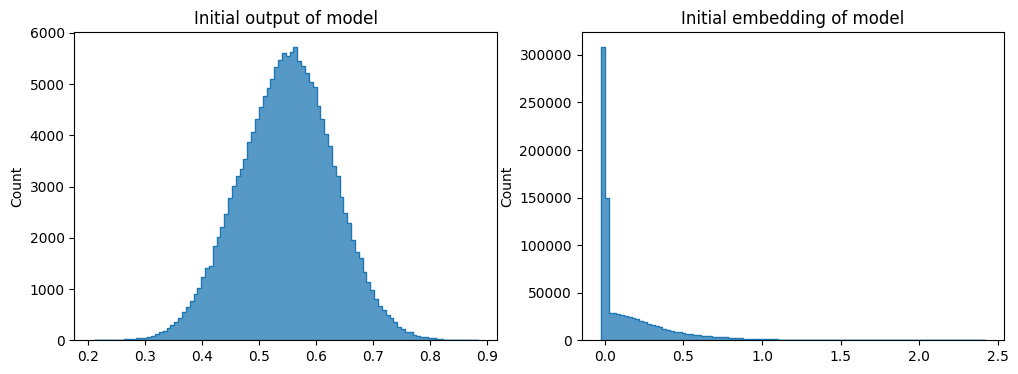

In [25]:
fig = plt.figure(figsize=(2*6, 4))
plt.subplot(1,2,1)
sns.histplot(model(params, PRNG, x, cond).flatten(), bins=100, log_scale=[False, False], element='step', fill=True)
plt.title('Initial output of model')
plt.subplot(1,2,2)
sns.histplot(h.flatten(), bins=100, log_scale=[False, False], element='step', fill=True)
plt.title('Initial embedding of model')

## Init optimiser

In [26]:
optimiser = make_optimiser(LEARNING_RATE_SCHED, LEARNING_RATE,
                           EPOCHS, L2_REG_ALPHA, USE_WARMUP, WARMUP_EPOCHS, N_BATCHES)
optimiser_state = optimiser.init(x)

# Train

In [27]:
x = f_reshape(x)
y = f_reshape(x)
cond = f_reshape(cond)


x_train, cond_train, y_train = x[:int(TRAIN_SPLIT * N_BATCHES)], cond[:int(TRAIN_SPLIT * N_BATCHES)], y[:int(TRAIN_SPLIT * N_BATCHES)]
x_val, cond_val, y_val = x[int(TRAIN_SPLIT * N_BATCHES):], cond[int(TRAIN_SPLIT * N_BATCHES):], y[int(TRAIN_SPLIT * N_BATCHES):]

x_train.shape

(176, 128, 6)

In [28]:
np.prod(x_train.shape[:2]), np.prod(x_val.shape[:2])


(np.int64(22528), np.int64(5760))

In [29]:
def train_step(params, x, y, cond, optimiser_state, model, rng, use_l2_reg, l2_reg_alpha, optimiser, loss_fn):

    loss, grads = jax.value_and_grad(loss_fn)(
        params, rng, model, x, y, use_l2_reg=use_l2_reg, l2_reg_alpha=l2_reg_alpha, cond=cond)

    updates, optimiser_state = optimiser.update(grads, optimiser_state)
    params = optax.apply_updates(params, updates)

    return params, optimiser_state, loss, grads


def eval_step(params, rng, model, x, y, cond, use_l2_reg, l2_reg_alpha, loss_fn, compute_accuracy):
    """ Return the average of loss and accuracy on validation data """
    loss = loss_fn(params, rng, model, x, y, use_l2_reg=use_l2_reg, l2_reg_alpha=l2_reg_alpha, cond=cond)
    pred_y = model(params, rng, x, cond=cond)
    acc = compute_accuracy(pred_y, y)
    return acc, loss


def run_batches(params, model, rng,
                x_batch, y_batch, cond_batch,
                use_l2_reg, l2_reg_alpha, optimiser, optimiser_state, loss_fn):

    f_train_step = partial(train_step, model=model, rng=rng,
                           use_l2_reg=use_l2_reg, l2_reg_alpha=l2_reg_alpha, optimiser=optimiser,
                           loss_fn=loss_fn)

    def f(carry, inp):

        params, optimiser_state = carry[0], carry[1]
        x_batch, y_batch, cond_batch = inp[0], inp[1], inp[2]

        params, optimiser_state, loss, grads = f_train_step(
            params, x_batch, y_batch, cond_batch, optimiser_state)
        return (params, optimiser_state), (loss, grads)

    # for x_batch, y_batch in xy_train:
    (params, optimiser_state), (train_loss, grads) = jax.lax.scan(
        f, (params, optimiser_state), (x_batch, y_batch, cond_batch))
    return params, optimiser_state, train_loss, grads


def train(params, rng, model,
          x_train, cond_train, y_train, x_val, cond_val, y_val,
          optimiser, optimiser_state,
          use_l2_reg, l2_reg_alpha, epochs,
          loss_fn, compute_accuracy,
          save_every, include_params_in_saves):

    def f(carry, _):
        params, optimiser_state = carry[0], carry[1]

        params, optimiser_state, train_loss, grads = run_batches(
            params, model, rng, x_train, y_train, cond_train, use_l2_reg, l2_reg_alpha, optimiser, optimiser_state, loss_fn)

        val_acc, val_loss = eval_step(
            params, rng, model, x_val, y_val, cond_val, use_l2_reg, l2_reg_alpha, loss_fn, compute_accuracy)

        return (params, optimiser_state), (params, grads, train_loss, val_loss, val_acc)

    saves = {}
    for e in range(epochs):
        (params, optimiser_state), (params_stack, grads, train_loss,
                                    val_loss, val_acc) = f((params, optimiser_state), None)

        if np.mod(e, save_every) == 0:
            saves[e] = make_saves(
                train_loss, val_loss, val_acc, include_params_in_saves, params_stack, grads)
            print(
                f'Epoch {e} / {epochs} -\t\t Train loss: {np.mean(train_loss)}\tVal loss: {val_loss}\tVal accuracy: {val_acc}')

    saves[list(saves.keys())[-1]]['params'] = params
    return params, saves

Text(0.5, 1.0, 'Preprocessing of input data')

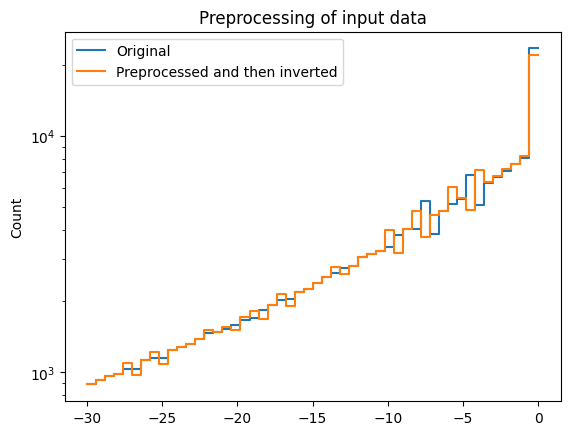

In [30]:
sns.histplot(np.concatenate([df_bal[i].iloc[:TOTAL_DS].values[:, None] for i in X_COLS], axis=1).squeeze().flatten(), bins=50, log_scale=[False, True], element='step', fill=False, label='Original')
sns.histplot(x_datanormaliser.create_chain_preprocessor_inverse(x_methods_preprocessing)(x).flatten(), bins=50, log_scale=[False, True], element='step', fill=False, label='Preprocessed and then inverted')
plt.legend()
plt.title('Preprocessing of input data')


## Run train

In [115]:
tstart = datetime.now()
params, saves = train(params, PRNG, model, 
                      x_train, cond_train, y_train, x_val, cond_val, y_val, 
                      optimiser, optimiser_state,
                      use_l2_reg=USE_L2_REG, l2_reg_alpha=L2_REG_ALPHA, epochs=EPOCHS,
                      loss_fn=loss_fn, compute_accuracy=accuracy_regression,
                      save_every=PRINT_EVERY, include_params_in_saves=False) 

print(datetime.now() - tstart)

/tmp/ipykernel_2522857/883534526.py:66: RuntimeWarning: divide by zero encountered in remainder
  if np.mod(e, save_every) == 0:


Epoch 0 / 2 -		 Train loss: 1.2224228382110596	Val loss: 1.2274450063705444	Val accuracy: 0.08371803909540176
Epoch 1 / 2 -		 Train loss: 1.2117818593978882	Val loss: 1.2114156484603882	Val accuracy: 0.0836588591337204
0:00:04.804876


/tmp/ipykernel_2522857/883534526.py:66: RuntimeWarning: divide by zero encountered in remainder
  if np.mod(e, save_every) == 0:


# Visualise

Text(0.5, 0.98, 'Training')

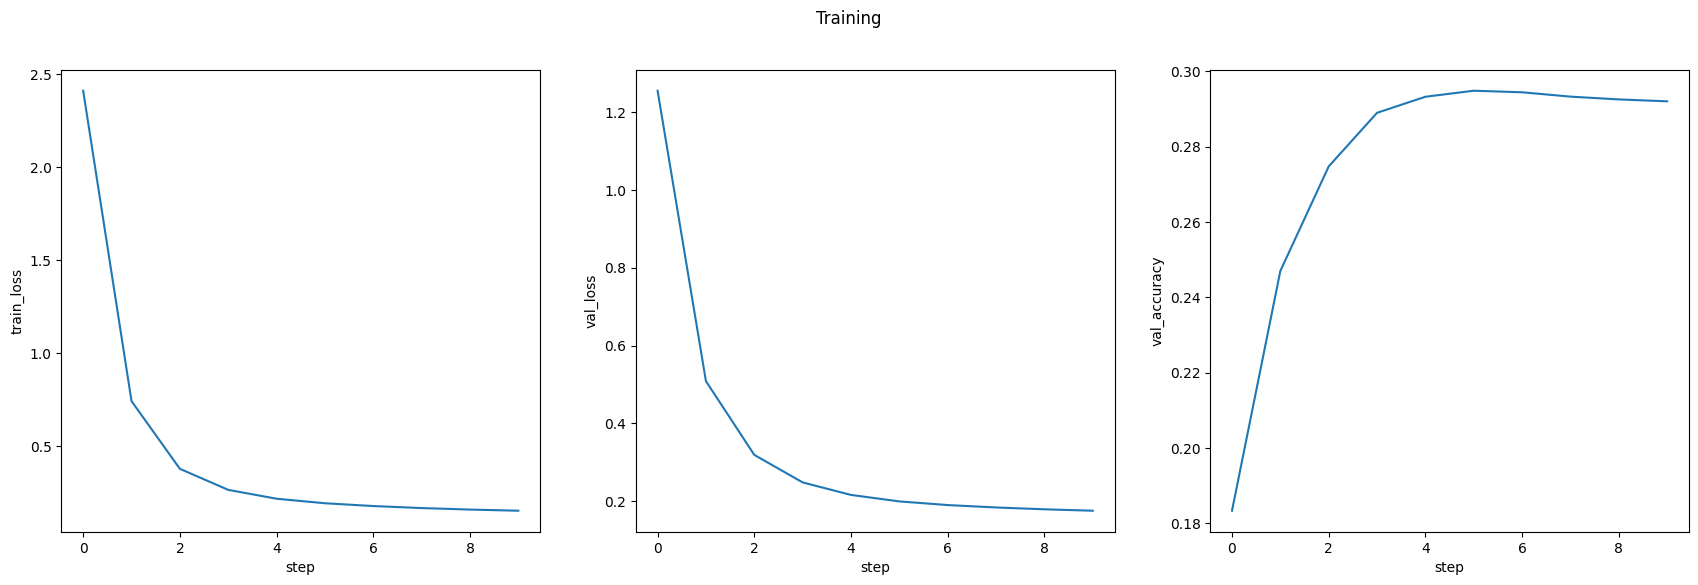

In [ ]:
plt.figure(figsize=(7*3, 6))
ax = plt.subplot(1, 3, 1)
plt.plot(list(saves.keys()), [v['train_loss'] for v in saves.values()])
plt.ylabel('train_loss')
plt.xlabel('step')
ax = plt.subplot(1, 3, 2)
plt.plot(list(saves.keys()), [v['val_loss'] for v in saves.values()])
plt.ylabel('val_loss')
plt.xlabel('step')
ax = plt.subplot(1, 3, 3)
plt.plot(list(saves.keys()), [v['val_accuracy'] for v in saves.values()])
plt.ylabel('val_accuracy')
plt.xlabel('step')

plt.suptitle('Training')

In [ ]:
write_json(saves, out_path=save_path)

In [ ]:
print(save_path)

weight_saves/01_cvae/2024_12_08__18_54_32_saves_test


# Examine trained model

In [31]:
fn_saves = os.path.join('weight_saves', '01_cvae', '2024_11_27__15_01_35_saves_test')
fn_saves = os.path.join('weight_saves', '01_cvae', '2024_11_27__16_58_36_saves_test')
fn_saves = os.path.join('weight_saves', '01_cvae', '2024_11_28__14_12_59_saves_test')
fn_saves = os.path.join('weight_saves', '01_cvae', '2024_11_29__10_43_59_saves_test')
fn_saves = os.path.join('weight_saves', '01_cvae', '2024_12_02__13_49_00_saves_test')  # sensitivity
fn_saves = os.path.join('weight_saves', '01_cvae', '2024_12_06__14_54_23_saves_test')  # generated from interactions
fn_saves = os.path.join('weight_saves', '01_cvae', '2024_12_06__17_57_39_saves_test')  # generated from interactions with sigmoid in decoder for 500 epochs
fn_saves = os.path.join('weight_saves', '01_cvae', '2024_12_08__17_45_52_saves_no_sigmoid_decoder')  # generated from interactions with sigmoid in decoder for 2000 epochs
fn_saves = os.path.join('weight_saves', '01_cvae', '2024_12_08__18_59_40_saves_KL_div')  # generated from interactions + relu + sigmoid + KL divergence
fn_saves = os.path.join('weight_saves', '01_cvae', '2024_12_08__20_55_42_saves_no_KL')  # generated from interactions + relu + sigmoid
fn_saves = os.path.join('weight_saves', '01_cvae', '2024_12_08__21_21_04_saves_no_KL')  # generated from interactions + relu 
fn_saves = os.path.join('weight_saves', '01_cvae', '2024_12_08__22_17_13_saves_leaky_relu')  # generated from interactions + leaky relu 
fn_saves = os.path.join('weight_saves', '01_cvae', '2024_12_08__22_48_33_saves_KL_leakyrelu')  # generated from interactions + leaky relu + KL
fn_saves = os.path.join('weight_saves', '01_cvae', '2024_12_08__23_01_53_saves_KL_leakyrelu')  # generated from interactions + leaky relu + KL + encoder head hidden size
fn_saves = os.path.join('weight_saves', '01_cvae', '2024_12_09__14_24_25_saves_new_MLP')  # generated from interactions + new MLP
fn_saves = os.path.join('weight_saves', '01_cvae', '2024_12_09__15_28_08_saves_layers_1')  # generated from interactions + only 1 layer for enc and dec
fn_saves = os.path.join('weight_saves', '01_cvae', '2024_12_09__15_51_40_saves_he_init')  # generated from interactions + only 1 layer for enc and dec
fn_saves = os.path.join('weight_saves', '01_cvae', '2024_12_09__16_13_34_saves_he_init_KL_ls1')  # generated from interactions + only 1 layer for enc and dec + KL
fn_saves = os.path.join('weight_saves', '01_cvae', '2024_12_09__16_49_29_saves_robust_KL_e2000')  # generated from interactions + KL + robust scaling + 2000 epochs
saves_loaded = load_json_as_dict(fn_saves)

p = saves_loaded[str(list(saves_loaded.keys())[-1])]['params']
p = arrayise(p)
# p['vae/~/h2mu'] = p.pop('vae/~/linear')
# p['vae/~/h2logvar'] = p.pop('vae/~/linear_1')

pred_y = model(p, PRNG, x, cond)
pred_y.shape

(221, 128, 6)

Text(0.5, 0, 'step')

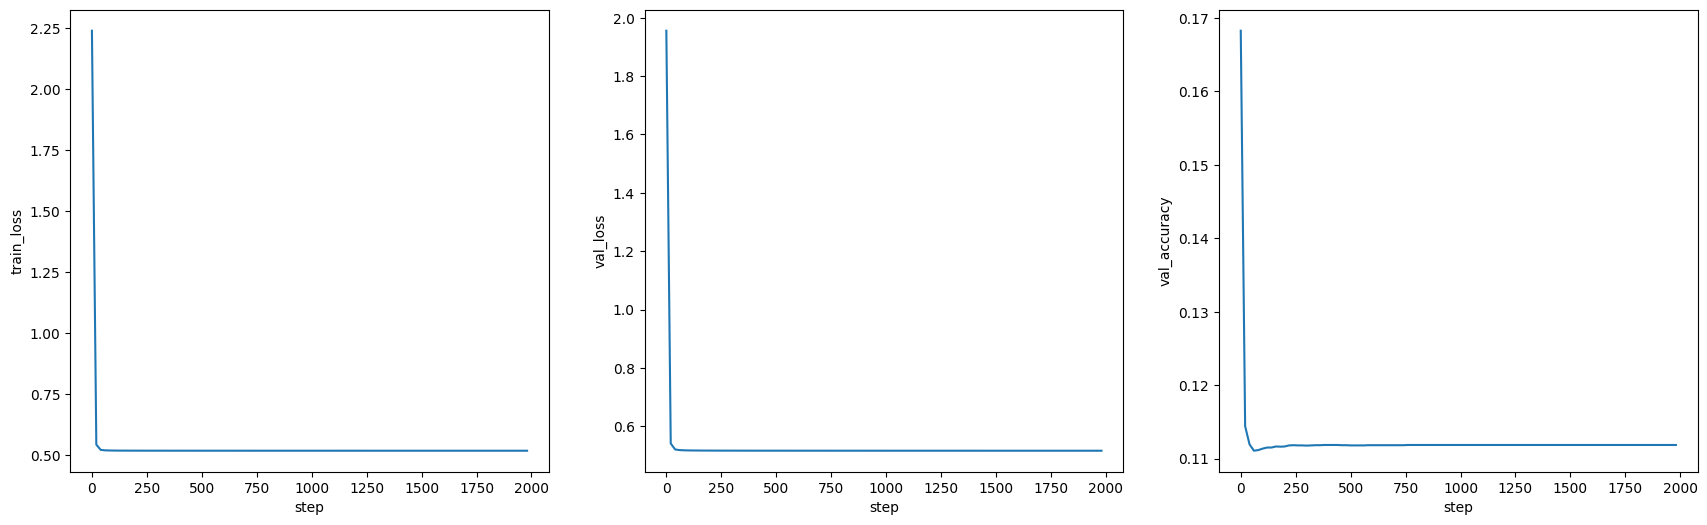

In [32]:
plt.figure(figsize=(7*3, 6))
ax = plt.subplot(1, 3, 1)
plt.plot(list(map(float, saves_loaded.keys())), np.array([float(v['train_loss']) for v in saves_loaded.values()]))
plt.ylabel('train_loss')
plt.xlabel('step')
ax = plt.subplot(1, 3, 2)
plt.plot(list(map(float, saves_loaded.keys())), np.array([float(v['val_loss']) for v in saves_loaded.values()]))
plt.ylabel('val_loss')
plt.xlabel('step')
ax = plt.subplot(1, 3, 3)
plt.plot(list(map(float, saves_loaded.keys())), np.array([float(v['val_accuracy']) for v in saves_loaded.values()]))
plt.ylabel('val_accuracy')
plt.xlabel('step')

The R2 score is  -0.08044660091400146
The R2 score with weighted variance is  -0.08044660091400146


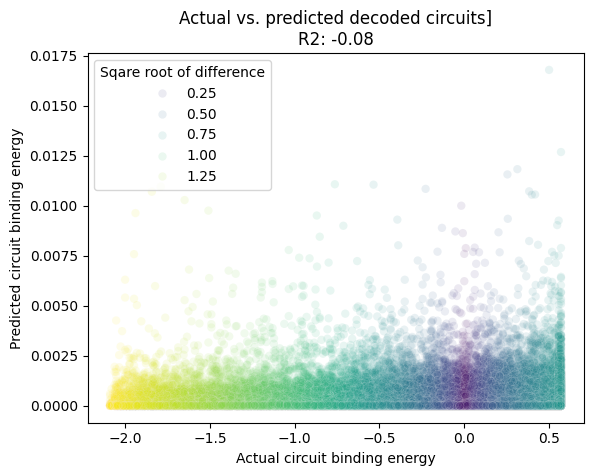

In [ ]:
g = sns.scatterplot(x=y.flatten(), y=pred_y.flatten(), alpha=0.1, hue=np.sqrt(np.abs(pred_y.flatten() - y.flatten())), palette='viridis')
g.legend_.set_title('Sqare root of difference')
plt.title(f'Actual vs. predicted decoded circuits\nR2: {r2_score(y.flatten(), pred_y.flatten()):.2f}')
plt.xlabel('Actual circuit binding energy')
plt.ylabel('Predicted circuit binding energy')

print('The R2 score is ', r2_score(y.flatten(), pred_y.flatten()))
print('The R2 score with weighted variance is ', r2_score(
    y.flatten(), pred_y.flatten(), multioutput='variance_weighted'))

# Sample fake circuits

In [270]:
n_to_sample = 10000

sampled_cond = np.interp(jax.random.normal(PRNG, (n_to_sample, cond.shape[-1])), [0, 1], [cond.min(), cond.max()])
sampled_h = np.random.rand(n_to_sample, ENC_LS)
# mu = np.random.normal(size=(n_to_sample, HIDDEN_SIZE)) * 10
# logvar = np.random.normal(size=(n_to_sample, HIDDEN_SIZE)) * 0.5
# mu = h2mu(p, PRNG, sampled_h) 
# logvar = h2logvar(p, PRNG, sampled_h)
# z = sample_z(mu=mu, logvar=logvar, key=PRNG)
z = jax.random.normal(PRNG, (n_to_sample, HIDDEN_SIZE))
z = np.concatenate([z, sampled_cond], axis=-1)

fake_circuits = decoder(p, PRNG, z)
# fake_circuits = np.where(fake_circuits > 0, 0, fake_circuits)
sampled_cond.shape

(10000, 1)

Text(0.5, 1.0, 'Generated fake circuits')

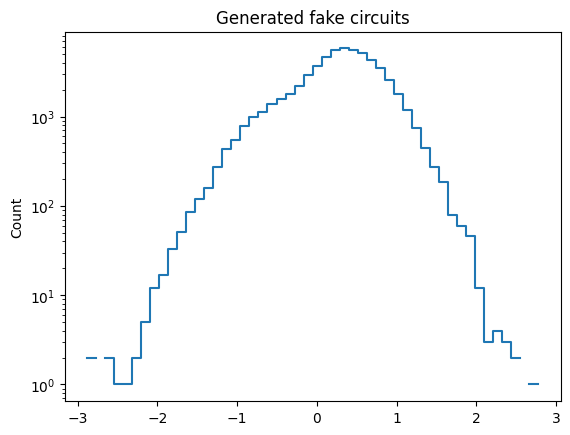

In [272]:
sns.histplot(fake_circuits.flatten(), bins=50, log_scale=[False, True], element='step', fill=False)
plt.title('Generated fake circuits')

Text(0.5, 0.98, 'Interactions for CVAE: 10000 circuits')

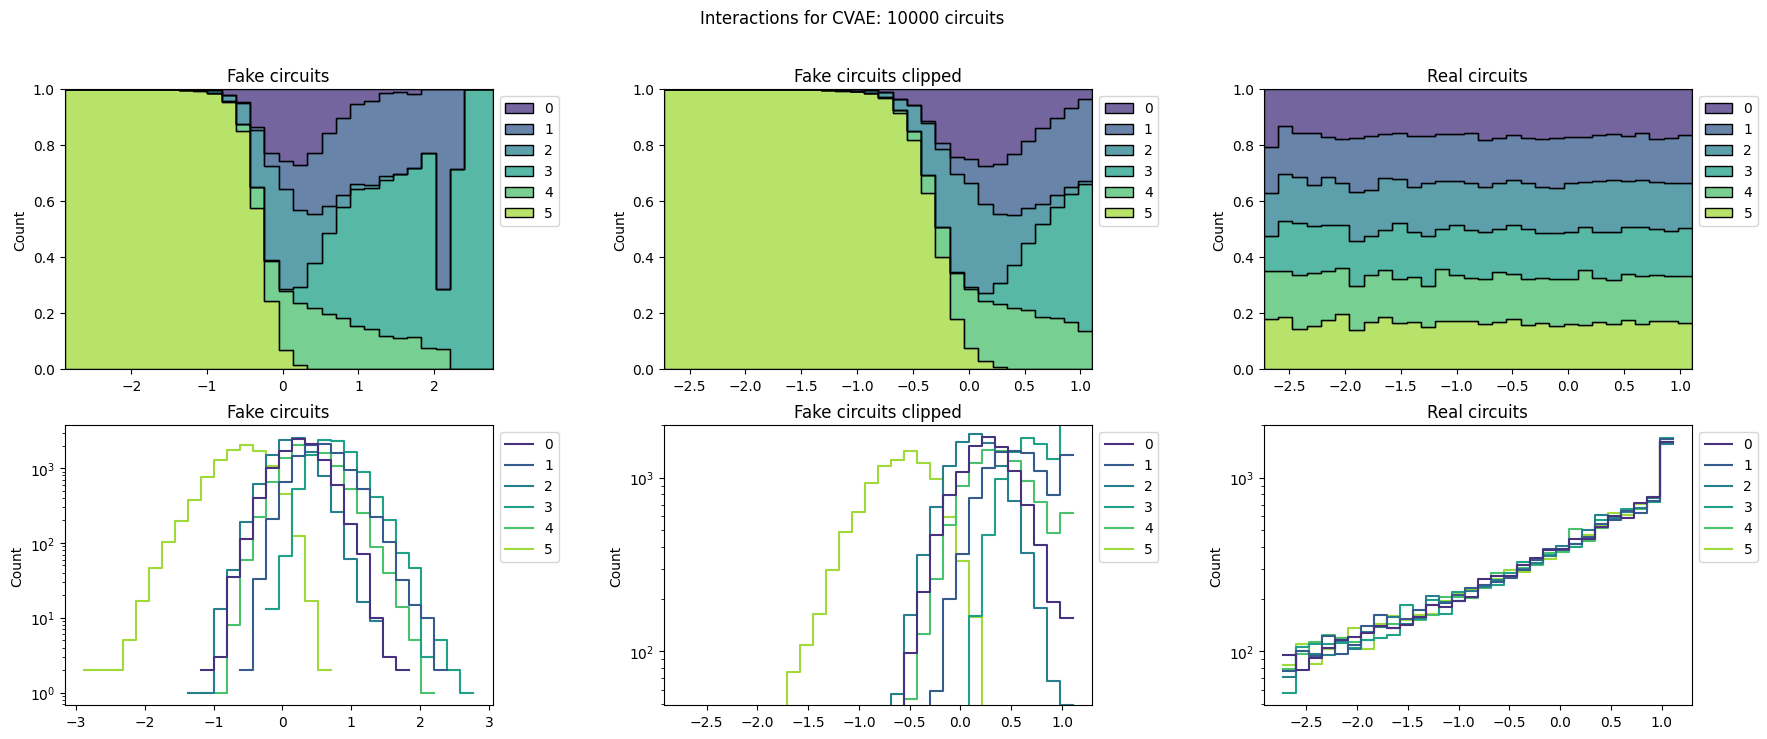

In [273]:
fig = plt.figure(figsize=(7*3, 8))
fig.subplots_adjust(wspace=0.4)

ax = plt.subplot(2, 3, 1)
g = sns.histplot(fake_circuits, element='step', bins=30,
                 palette='viridis', multiple='fill')
plt.title('Fake circuits')
sns.move_legend(g, 'upper left', bbox_to_anchor=(1, 1))

ax = plt.subplot(2, 3, 2)
g = sns.histplot(np.where(fake_circuits > x.max(), x.max(), np.where(fake_circuits < x.min(), x.min(), fake_circuits)), 
                 element='step', bins=30,
                 palette='viridis', multiple='fill')
plt.title('Fake circuits clipped')
sns.move_legend(g, 'upper left', bbox_to_anchor=(1, 1))

ax = plt.subplot(2, 3, 3)
g = sns.histplot(x.reshape(np.prod(x.shape[:-1]), x.shape[-1])[:n_to_sample],
                 element='step', bins=30, palette='viridis', multiple='fill')
plt.title('Real circuits')
sns.move_legend(g, 'upper left', bbox_to_anchor=(1, 1))

ax = plt.subplot(2, 3, 4)
g = sns.histplot(fake_circuits, element='step', bins=30, palette='viridis',
                 multiple='layer', fill=False, log_scale=[False, True])
plt.title('Fake circuits')
sns.move_legend(g, 'upper left', bbox_to_anchor=(1, 1))

ax = plt.subplot(2, 3, 5)
g = sns.histplot(np.where(fake_circuits > x.max(), x.max(), np.where(fake_circuits < x.min(), x.min(), fake_circuits)), 
                 element='step', bins=30, palette='viridis',
                 multiple='layer', fill=False, log_scale=[False, True])
plt.title('Fake circuits clipped')
sns.move_legend(g, 'upper left', bbox_to_anchor=(1, 1))

ax = plt.subplot(2, 3, 6)
x_hist = x.reshape(np.prod(x.shape[:-1]), x.shape[-1])[:n_to_sample]
g2 = sns.histplot(x_hist, element='step', bins=30, palette='viridis',
                  multiple='layer', fill=False, log_scale=[False, True])
plt.title('Real circuits')
sns.move_legend(g2, 'upper left', bbox_to_anchor=(1, 1))

g.set_ylim(g2.get_ylim())

plt.suptitle(f'Interactions for CVAE: {n_to_sample} circuits')

Text(0.5, 0.98, 'CVAE: 2000 circuits')

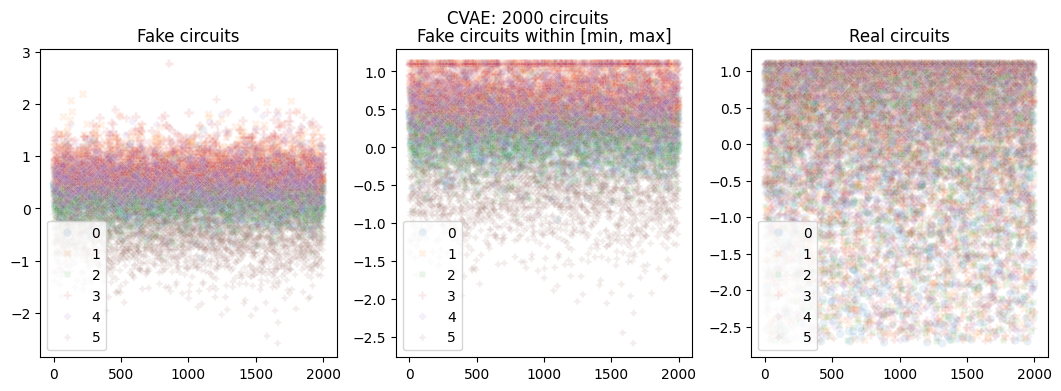

In [274]:
fig = plt.figure(figsize=(13, 4))

show_max = 2000

ax = plt.subplot(1, 3, 1)
sns.scatterplot(fake_circuits[:show_max], alpha=0.1)
plt.title('Fake circuits')

ax = plt.subplot(1, 3, 2)
fake_circuits_1 = np.where(fake_circuits[:show_max] > x.max(), x.max(), fake_circuits[:show_max])
sns.scatterplot(np.where(fake_circuits_1 < x.min(), x.min(), fake_circuits_1), alpha=0.1)
plt.title('Fake circuits within [min, max]')

ax = plt.subplot(1, 3, 3)
sns.scatterplot(
    x.reshape(np.prod(x.shape[:-1]), x.shape[-1])[:show_max], alpha=0.1)
plt.title('Real circuits')

plt.suptitle(f'CVAE: {show_max} circuits')

## Conditionality

In [230]:
n_categories = 5
n_to_sample = 10000

sampled_cond = np.repeat(np.linspace(cond.min(), cond.max(), n_categories)[:, None], repeats=n_to_sample, axis=1)[:, :, None]
mu = np.random.normal(size=(n_to_sample, HIDDEN_SIZE)) * 1
logvar = np.random.normal(size=(n_to_sample, HIDDEN_SIZE)) * 2
z = sample_z(mu=mu, logvar=logvar, key=PRNG)
z = np.repeat(z[None, :], repeats=n_categories, axis=0)
z = np.concatenate([z, sampled_cond], axis=-1)

fake_circuits = jax.vmap(partial(decoder, params=p, rng=PRNG))(inputs=z)
# fake_circuits = np.where(fake_circuits > 0, 0, fake_circuits)

Text(0.5, 0.98, 'CVAE: fake circuits')

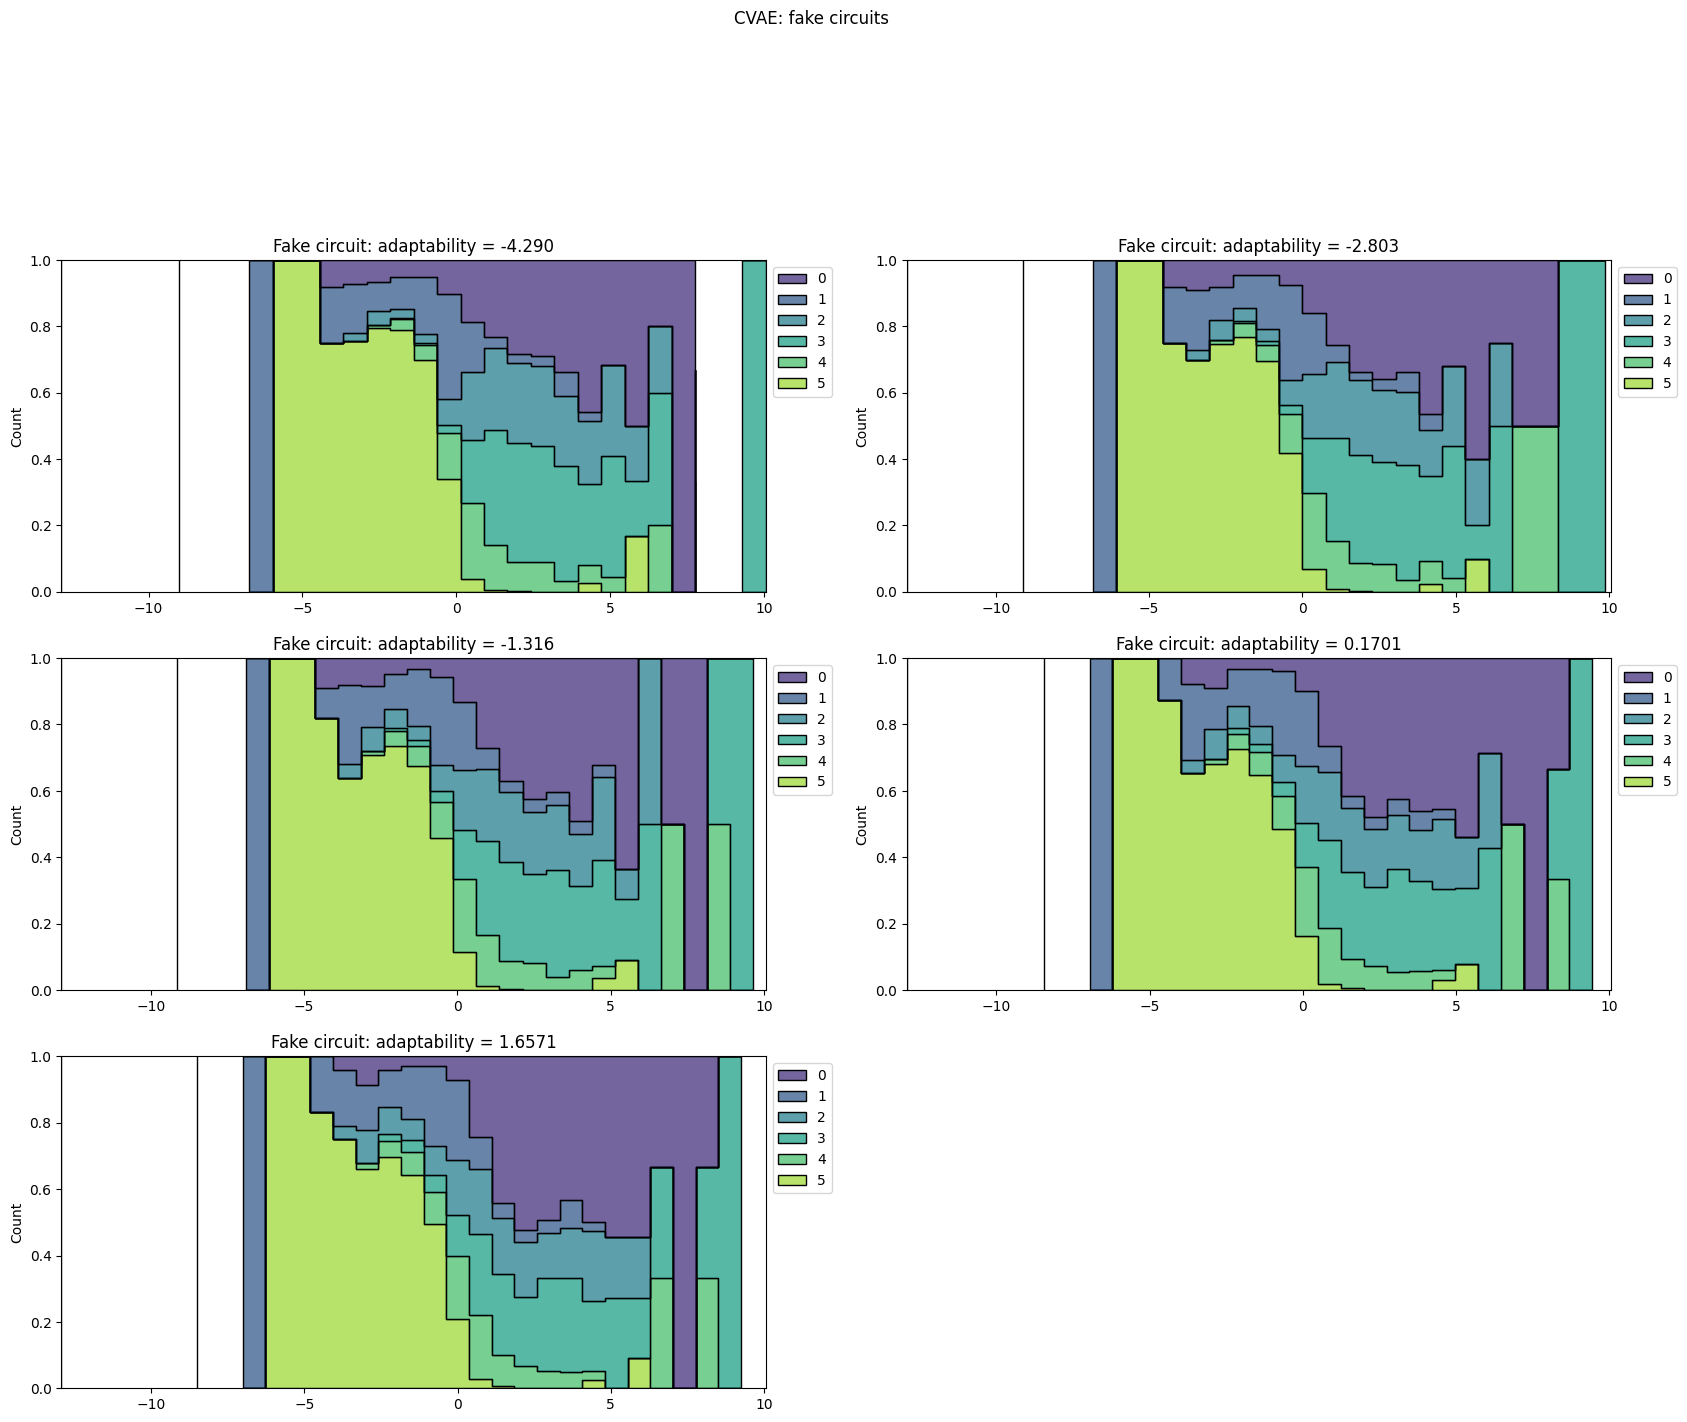

In [231]:
fig = plt.figure(figsize=(10*2, 5*5))
show_max = 300 #n_to_sample
widest_lim = [0, 0]
for i, (zi, cat) in enumerate(zip(z, fake_circuits)):
    ax = plt.subplot(5, 2, i+1)
    # g = sns.scatterplot(cat[:show_max])
    g = sns.histplot(cat, element='step', bins=30, palette='viridis', multiple='fill')
    plt.title(f'Fake circuit: {OBJECTIVE_COL} = {str(sorted(np.unique(sampled_cond))[i])[:6]}')
    sns.move_legend(g, 'upper left', bbox_to_anchor=(1, 1))
    widest_lim[0] = np.min([g.get_xlim()[0], widest_lim[0]])
    widest_lim[1] = np.max([g.get_xlim()[1], widest_lim[1]])
    g.set_xlim(widest_lim)

plt.suptitle(f'CVAE: fake circuits')

## Compare to real circuit's objective

In [232]:
def round_to_nearest_array(x, y):
    """ 
    x: array to be mapped over
    y: array with integers to round to """
    distances = np.abs(x[:, None] - y[None, :])
    nearest_indices = np.argmin(distances, axis=1)
    nearest_values = y[nearest_indices]
    return nearest_values


def bin_to_nearest_edge(x: np.ndarray, n_bins):
    """ Bin the elements in x to the nearest lowest bin """
    edges = np.linspace(x.min(), x.max(), n_bins)
    return round_to_nearest_array(x, edges)


def apply_fns(x, fns: list):
    og_shape = x.shape
    if x.ndim > 2:
        x = x.reshape(*(np.prod(x.shape[:-1]), x.shape[-1]))
    for fcn in fns:
        x = fcn(x)
    return x.reshape(og_shape)

# df[OBJECTIVE_COL + '_nearest_edge'] = bin_to_nearest_edge(np.log10(df[OBJECTIVE_COL].to_numpy()), n_bins=n_categories)
# y_obj_all = df[OBJECTIVE_COL].to_numpy()
# for y_scale in y_scaling:
#     y_obj_all = y_scale(y_obj_all)
# df[OBJECTIVE_COL + '_nearest_edge'] = bin_to_nearest_edge(y_obj_all, n_bins=n_categories)
df = df[~df[OBJECTIVE_COL].isna()]
df[OBJECTIVE_COL + '_nearest_edge'] = bin_to_nearest_edge(df[OBJECTIVE_COL].to_numpy(), n_bins=n_categories)
fake_circuits = x_datanormaliser.create_chain_preprocessor_inverse(x_methods_preprocessing)(fake_circuits)


In [233]:
# fake_circuits = np.where(fake_circuits > df[X_COLS[0]].max().max(), df[X_COLS[0]].max().max(), fake_circuits)

Text(0.5, 0.98, 'CVAE: real circuits')

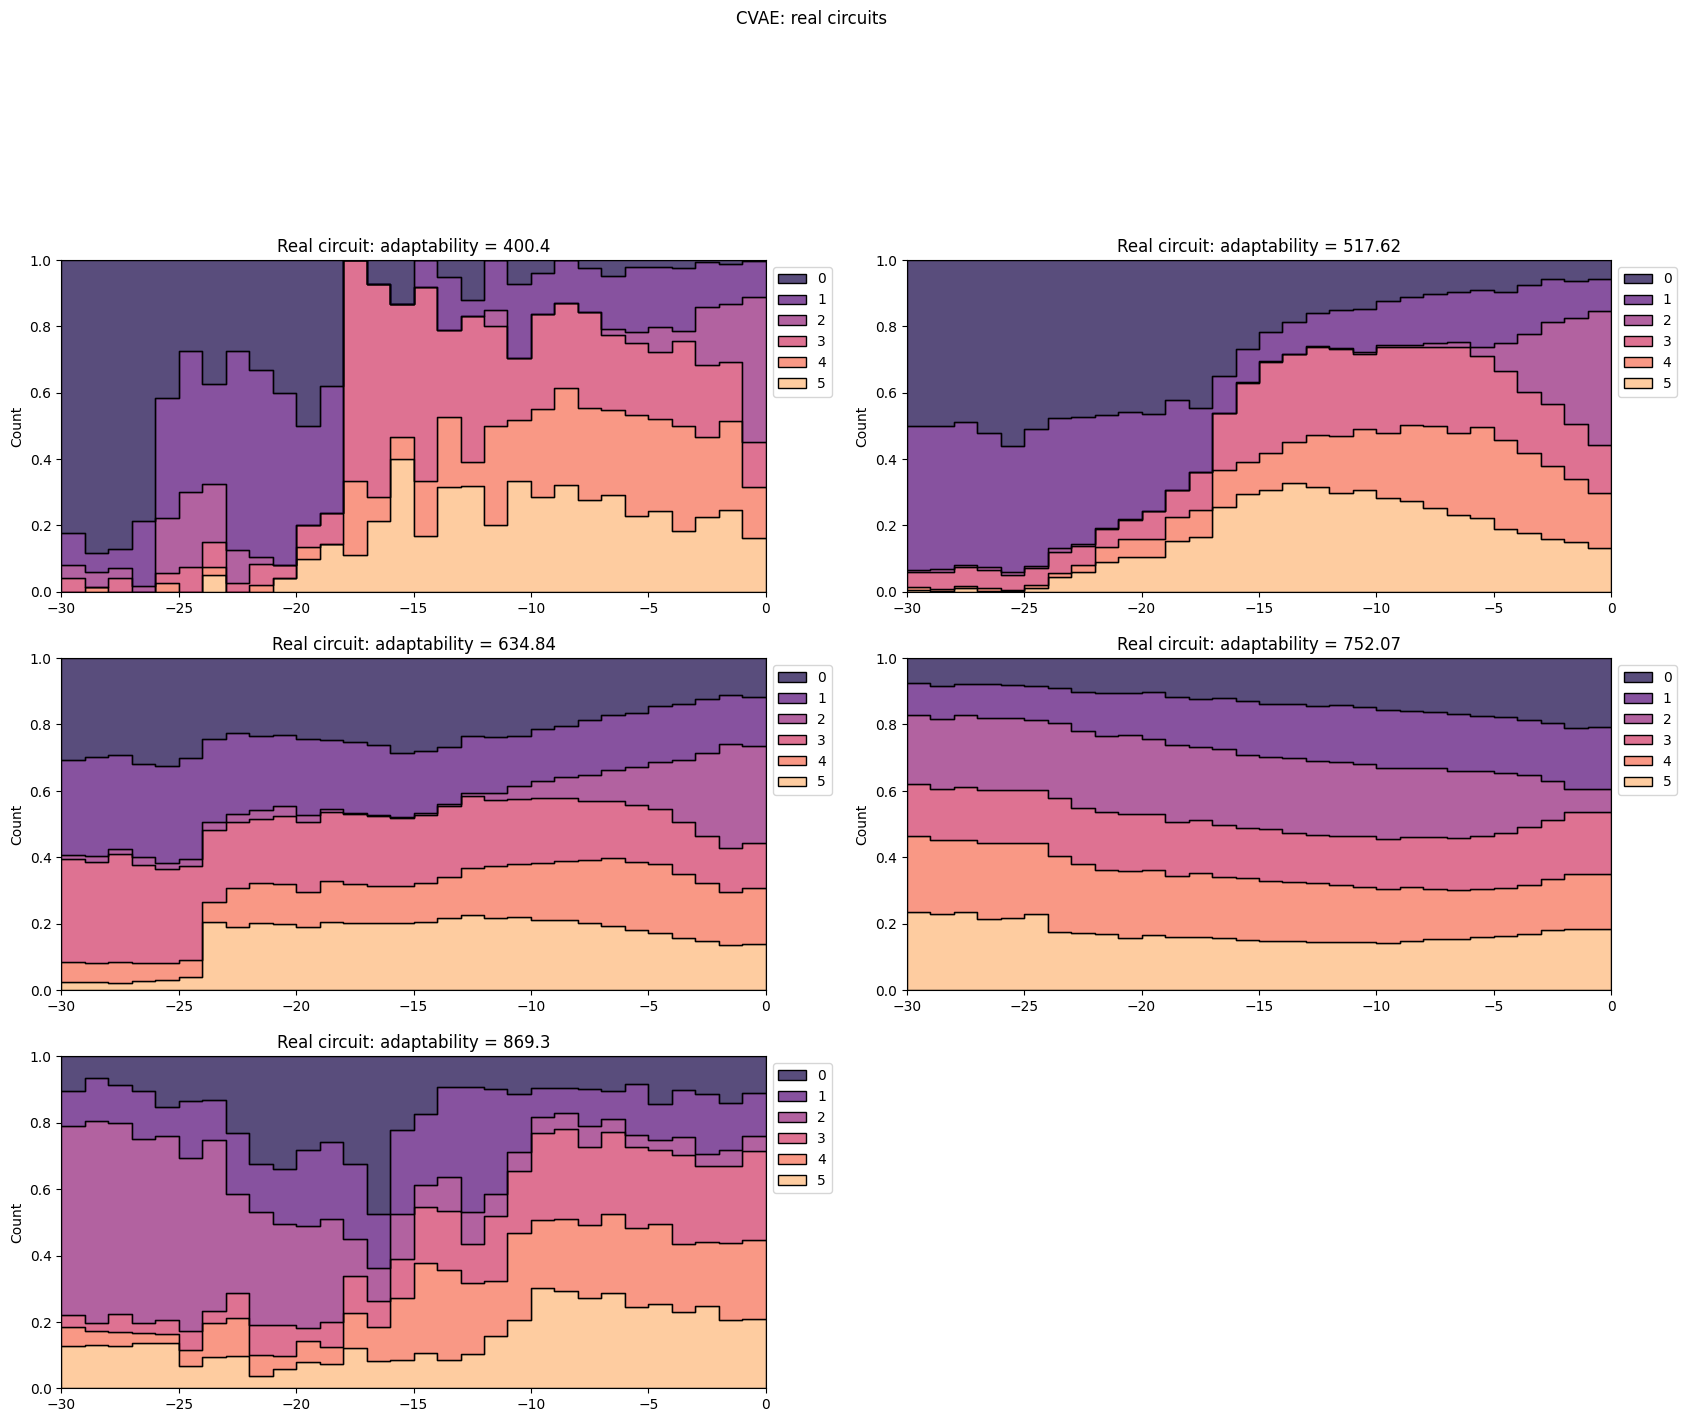

In [234]:
fig = plt.figure(figsize=(10*2, 5*5))
show_max = 300 #n_to_sample
widest_lim = [0, 0]
for i, edge in enumerate(sorted(df[OBJECTIVE_COL + '_nearest_edge'].unique())):
    cat = df[df[OBJECTIVE_COL + '_nearest_edge'] == edge]
    cat = cat[X_COLS].to_numpy()
    
    ax = plt.subplot(5, 2, i+1)
    # g = sns.scatterplot(cat[:show_max])
    g = sns.histplot(cat, element='step', bins=30, palette='magma', multiple='fill')
    plt.title(f'Real circuit: {OBJECTIVE_COL} = {str(edge)[:6]}')
    sns.move_legend(g, 'upper left', bbox_to_anchor=(1, 1))
    widest_lim[0] = np.min([g.get_xlim()[0], widest_lim[0]])
    widest_lim[1] = np.max([g.get_xlim()[1], widest_lim[1]])
    g.set_xlim(widest_lim)

plt.suptitle(f'CVAE: real circuits')

## Combined

Text(0.5, 0.98, 'CVAE: circuit comparison fake vs. real')

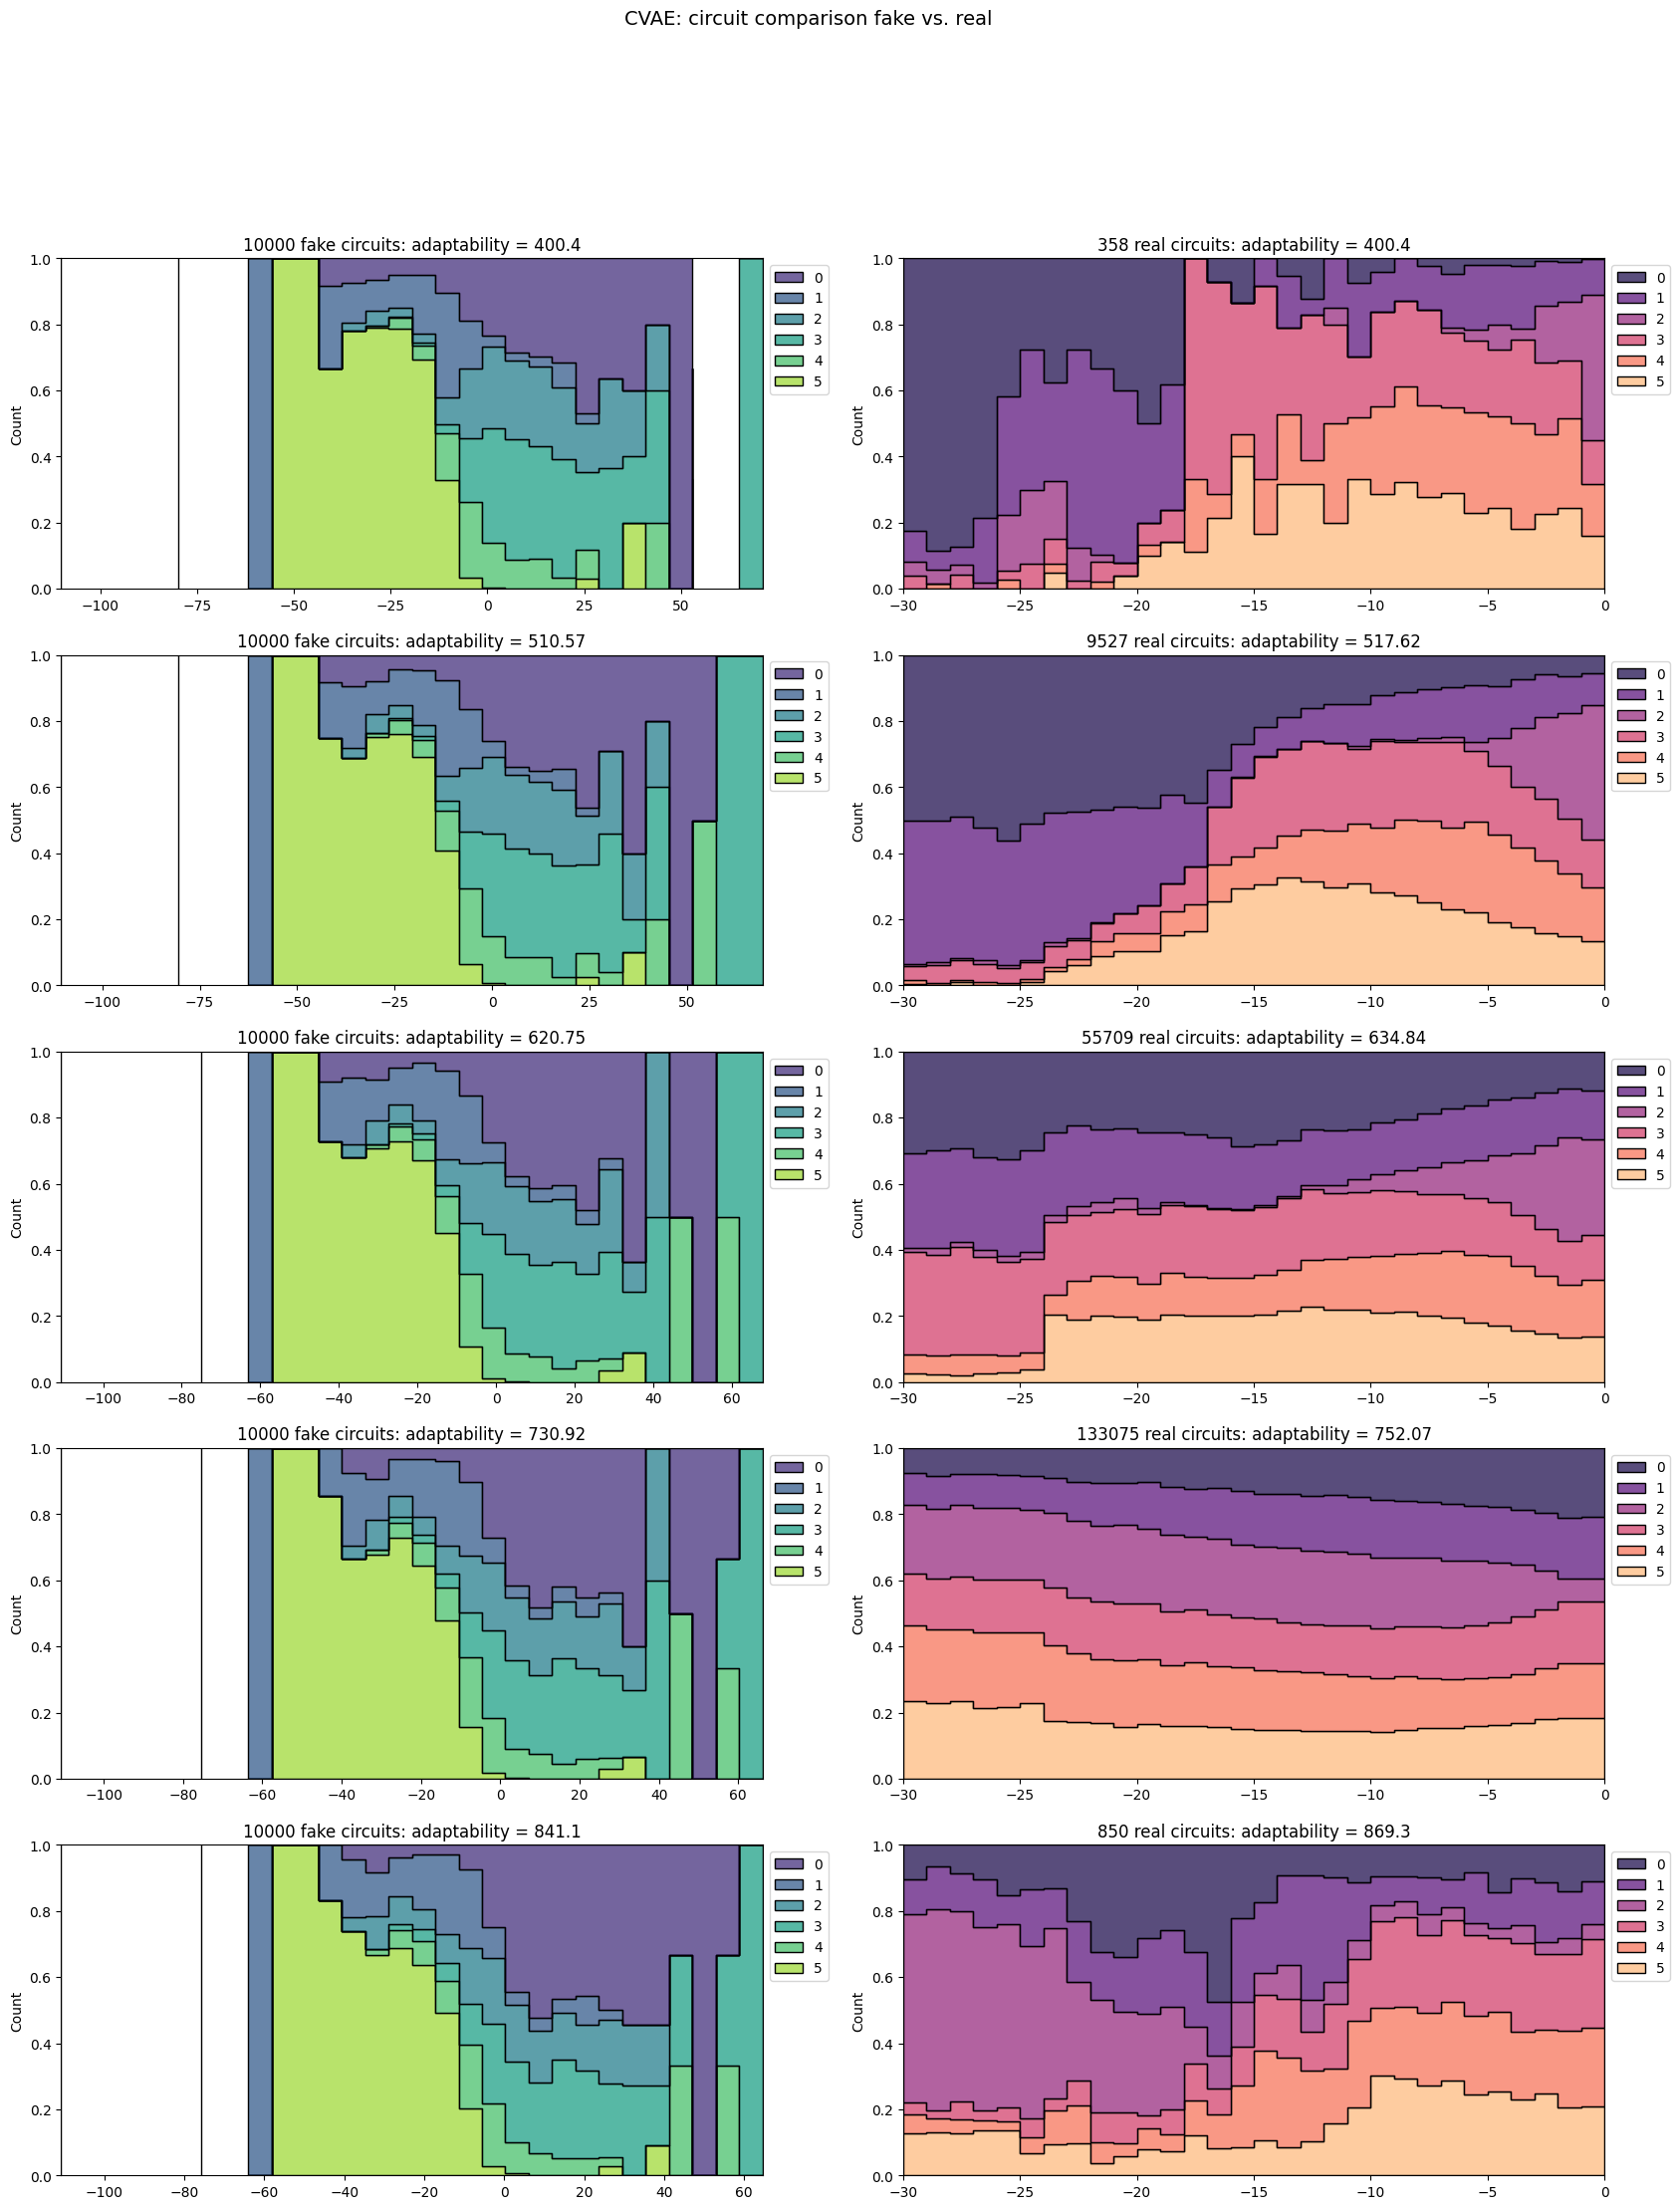

In [235]:
fig = plt.figure(figsize=(10*2, 5*5))
show_max = 300 #n_to_sample
for i, (zi, fake, edge) in enumerate(zip(z, fake_circuits, sorted(df[OBJECTIVE_COL + '_nearest_edge'].unique()))):
    widest_lim = [0, 0]
    real = df[df[OBJECTIVE_COL + '_nearest_edge'] == edge][X_COLS].to_numpy()
    
    ax = plt.subplot(5, 2, 2*i+1)
    # g = sns.scatterplot(cat[:show_max])
    g1 = sns.histplot(fake, element='step', bins=30, palette='viridis', multiple='fill')
    sc = np.array(sorted(np.unique(sampled_cond)))[:, None]
    sc = y_datanormaliser.create_chain_preprocessor_inverse(y_methods_preprocessing)(sc)
    plt.title(f'{len(fake)} fake circuits: {OBJECTIVE_COL} = {str(sc.flatten()[i])[:6]}')
    sns.move_legend(g1, 'upper left', bbox_to_anchor=(1, 1))
    
    ax = plt.subplot(5, 2, 2*i+2)
    # g = sns.scatterplot(cat[:show_max])
    g2 = sns.histplot(real, element='step', bins=30, palette='magma', multiple='fill')
    plt.title(f'{len(real)} real circuits: {OBJECTIVE_COL} = {str(edge)[:6]}')
    sns.move_legend(g2, 'upper left', bbox_to_anchor=(1, 1))
    
    widest_lim = [np.min([g1.get_xlim()[0], g2.get_xlim()[0], widest_lim[0]]), np.max([g1.get_xlim()[1], g2.get_xlim()[1], widest_lim[1]])]
    # g1.set_xlim(widest_lim)
    # g2.set_xlim(widest_lim)


plt.suptitle(f'CVAE: circuit comparison fake vs. real', fontsize=14)

Text(0.5, 0.98, 'CVAE: circuit comparison fake vs. real')

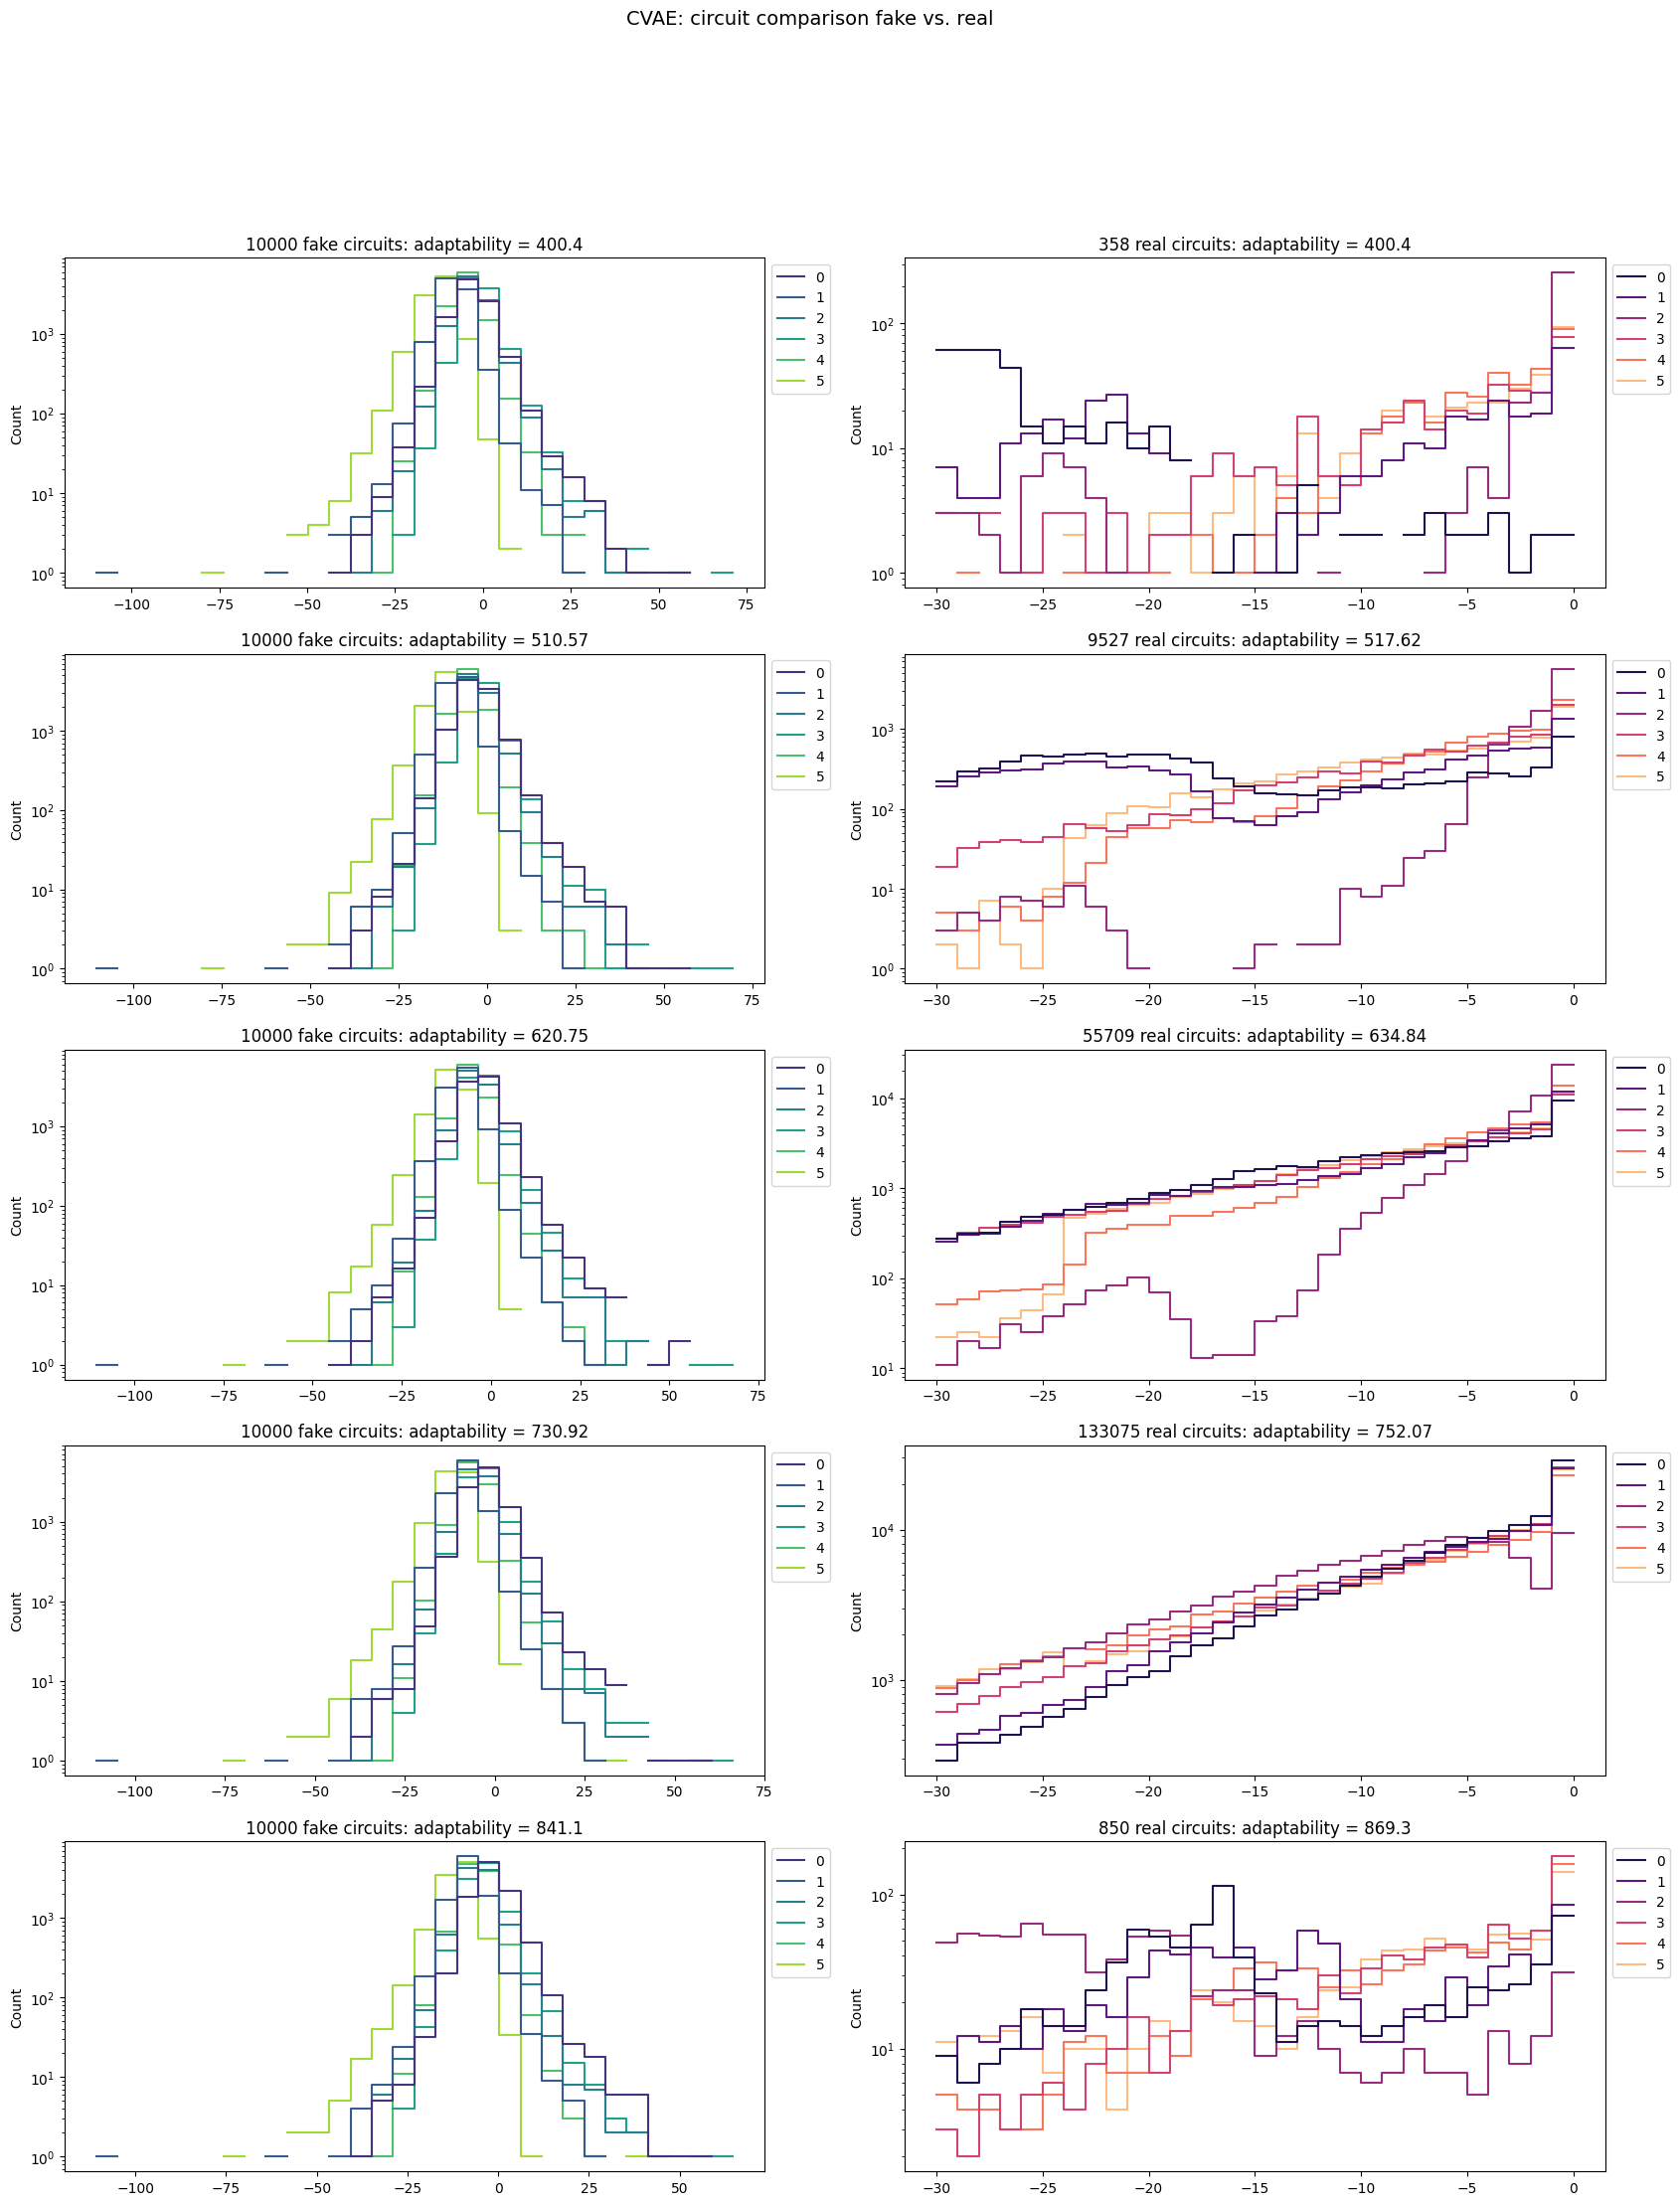

In [236]:
fig = plt.figure(figsize=(10*2, 5*5))
show_max = 300 #n_to_sample
for i, (zi, fake, edge) in enumerate(zip(z, fake_circuits, sorted(df[OBJECTIVE_COL + '_nearest_edge'].unique()))):
    real = df[df[OBJECTIVE_COL + '_nearest_edge'] == edge][X_COLS].to_numpy()
    
    ax = plt.subplot(5, 2, 2*i+1)
    # g = sns.scatterplot(cat[:show_max])
    g1 = sns.histplot(fake, element='step', bins=30, palette='viridis', multiple='layer', fill=False, log_scale=[False, True])
    sc = np.array(sorted(np.unique(sampled_cond)))[:, None]
    sc = y_datanormaliser.create_chain_preprocessor_inverse(y_methods_preprocessing)(sc)
    plt.title(f'{len(fake)} fake circuits: {OBJECTIVE_COL} = {str(sc.flatten()[i])[:6]}')
    sns.move_legend(g1, 'upper left', bbox_to_anchor=(1, 1))
    
    ax = plt.subplot(5, 2, 2*i+2)
    # g = sns.scatterplot(cat[:show_max])
    g2 = sns.histplot(real, element='step', bins=30, palette='magma', multiple='layer', fill=False, log_scale=[False, True])
    plt.title(f'{len(real)} real circuits: {OBJECTIVE_COL} = {str(edge)[:6]}')
    sns.move_legend(g2, 'upper left', bbox_to_anchor=(1, 1))
    
    widest_xlim = [np.min([g1.get_xlim()[0], g2.get_xlim()[0]]), np.max([g1.get_xlim()[1], g2.get_xlim()[1]])]
    widest_ylim = [np.min([g1.get_ylim()[0], g2.get_ylim()[0]]), np.max([g1.get_ylim()[1], g2.get_ylim()[1]])]
    # g1.set_xlim(widest_xlim)
    # g2.set_ylim(widest_ylim)


plt.suptitle(f'CVAE: circuit comparison fake vs. real', fontsize=14)